In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython import display


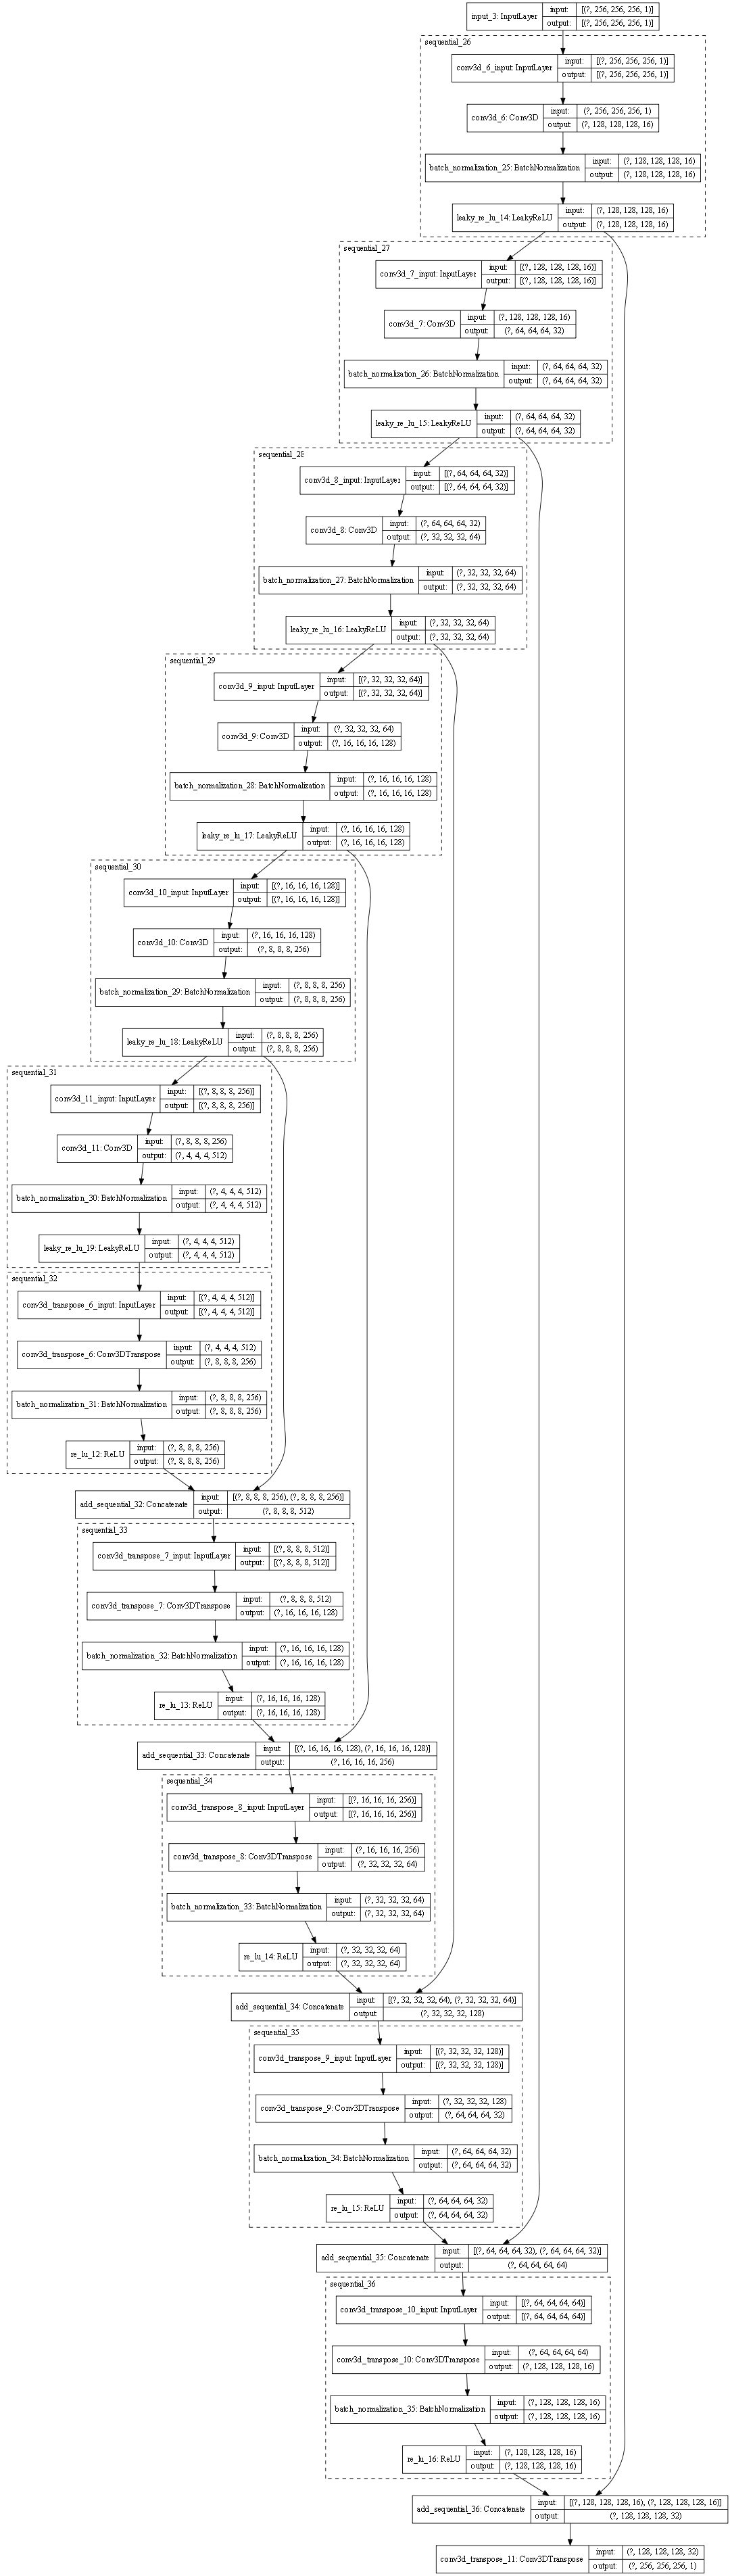

In [8]:
def generator_downsample(filters, size, apply_batchnorm = True):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Conv3D(filters, kernel_size=size, strides=2, padding="same")
    )
    if(apply_batchnorm):
        model.add(
            tf.keras.layers.BatchNormalization()
        )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    return model

def generator_upsample(filters, size, apply_dropout = False):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv3DTranspose(filters, kernel_size=size, strides=2, padding="same")
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    if(apply_dropout):
        model.add(
            tf.keras.layers.Dropout(0.5)
        )
    model.add(
        tf.keras.layers.ReLU()
    )
    return model

def build_generator():
    downsample_steps = [
        generator_downsample(16, 3),  # (?, 128, 128, 16)
        generator_downsample(32, 3),  # (?,  64,  64, 32)
        generator_downsample(64, 3),  # (?,  32,  32, 64)
        generator_downsample(128, 3), # (?,  16,  16, 128)
        generator_downsample(256, 3), # (?,   8,   8, 256)
        generator_downsample(512, 3), # (?,   4,   4, 512)
#         generator_downsample(512, 3), # (?, 2, 2, 512)
#         generator_downsample(512, 3), # (?, 1, 1, 512)
    ]

    upsample_steps = [
#         generator_upsample(512, 4, apply_dropout=True), # (?, 2, 2, 512)
#         generator_upsample(512, 4, apply_dropout=True), # (?, 4, 4, 512)
        generator_upsample(256, 3), # (?,   8,   8, 256)
        generator_upsample(128, 3), # (?,  16,  16, 128)
        generator_upsample( 64, 3), # (?,  32,  32,  64)
        generator_upsample( 32, 3), # (?,  64,  64,  32)
        generator_upsample( 16, 3), # (?, 128, 128,  16)
    ]

    inputs = tf.keras.layers.Input(shape = [256, 256, 256, 1])

    x = inputs
    generator_steps_otput = []
    for step in downsample_steps:
        x = step(x)
        generator_steps_otput.append(x)

    skip_conns = reversed(generator_steps_otput[:-1])
    for step, skip_conn in zip(upsample_steps, skip_conns):
        x = step(x)
        x = tf.keras.layers.Concatenate(name = "add_" + step.name)([x, skip_conn])

    output_layer = tf.keras.layers.Conv3DTranspose(1, kernel_size=4, strides=2, padding="same")(x)

    return tf.keras.models.Model(inputs=[inputs], outputs = [output_layer])

generator = build_generator()

tf.keras.utils.plot_model(generator, show_shapes=True, expand_nested=True,  dpi=64)

In [7]:
generator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 25 0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 128 512         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 64, 64, 64, 3 13984       sequential_15[0][0]              
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 32, 32, 32, 6 55616       sequential_16[0][0]              
_______________________________________________________________________________________